In [39]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from aesara import tensor as at
from bokeh.io import output_notebook, show
# from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.TrendComparison import DiffusionTrendComparison
import pysindy as ps
from pydmd import DMD


In [40]:
def get_trajectory_matrix(trend):
    return np.array([trend[0]['trends']['node_count'][i] for i in range(3)])

In [41]:
# Network topology
N_pop = 200
g = nx.erdos_renyi_graph(N_pop, .3)
N_sim = 1000
# 2° Model selection
models = [ep.SIRModel(g) for i in range(N_sim)]

# 2° Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.01)
cfg.add_model_parameter('gamma', 0.02)
cfg.add_model_parameter("fraction_infected", 0.1)
[model.set_initial_status(cfg) for model in models]
Nt = 200
trends = []
X = np.zeros((N_sim, 3, Nt))
for i, model in enumerate(models):
    iteration = model.iteration_bunch(Nt)
    
    trends.append(model.build_trends(iteration))
    X[i, :, :] = get_trajectory_matrix(trends[-1])
# 2° Simulation execution




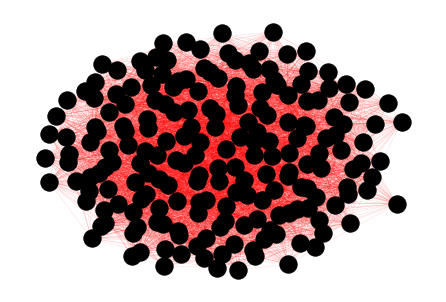

In [42]:
G = models[0].graph.graph
nx.draw(G, width=.1, style='dashed', edge_color='r', node_color='k')

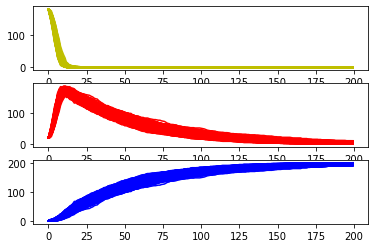

In [43]:
fig, ax = plt.subplots(3)
for traj in X:
    ax[0].plot(traj[0,:], color='y')
    ax[1].plot(traj[1,:], color='r')
    ax[2].plot(traj[2,:], color='b')
plt.show()

In [44]:
t = [*list(range(Nt))]*N_sim

In [45]:
X_2D = np.hstack([xk for xk in X])
threshold = 1e-6
reg_model = ps.SINDy(ps.FROLS(verbose=True),
feature_library=ps.PolynomialLibrary(degree=2))


reg_model.fit(X_2D[:,:Nt].T)
# dmd = DMD()
# dmd.fit(X_2D)
# for dynamics in dmd.dynamics:
#     plt.plot(t, dynamics.real)
reg_model.print()


 Iteration ... Index ... |y - Xw|^2 ...  a * |w|_2 ... |w|_0 ...  b * |w|_0 ... Total: |y-Xw|^2+a*|w|_2+b*|w|_0
 Note that these error metrics are related but not the same as the loss function being minimized by FROLS!
         0 ...     0 ... 3.2958e+03 ... 0.0000e+00 ...     0 ... 0.0000e+00 ... 3.2958e+03
         1 ...     0 ... 5.7054e+01 ... 2.9770e-07 ...     1 ... 0.0000e+00 ... 5.7054e+01
         2 ...     0 ... 9.6632e+01 ... 2.6641e-07 ...     2 ... 0.0000e+00 ... 9.6632e+01
         3 ...     0 ... 8.7583e+01 ... 1.0067e-06 ...     3 ... 0.0000e+00 ... 8.7583e+01
         4 ...     0 ... 1.2360e+31 ... 1.1606e+28 ...     4 ... 0.0000e+00 ... 1.2371e+31
         5 ...     0 ... 6.1736e+03 ... 9.3299e-03 ...     5 ... 0.0000e+00 ... 6.1736e+03
         6 ...     0 ... 7.6541e+03 ... 2.2769e-04 ...     6 ... 0.0000e+00 ... 7.6541e+03
         7 ...     0 ... 2.8119e+24 ... 5.1759e+18 ...     7 ... 0.0000e+00 ... 2.8119e+24
         8 ...     0 ... 1.0949e+04 ... 2.2627e-04 ..

/home/arch/Env/Default/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.11527e-37): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/arch/Env/Default/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.33156e-36): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/arch/Env/Default/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.2621e-33): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


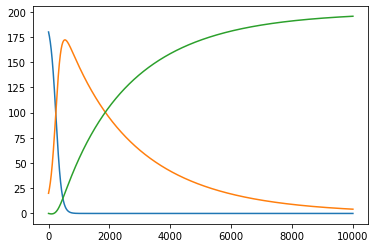

In [46]:
sim = reg_model.simulate(x0=X_2D[:,Nt], t=np.linspace(0,200, 10000))
plt.plot(sim)